1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


It is True that the 2 methods give almost the same result
[0.9326 0.     0.0674]


[-1.1000, 1.1000, -5, 5]

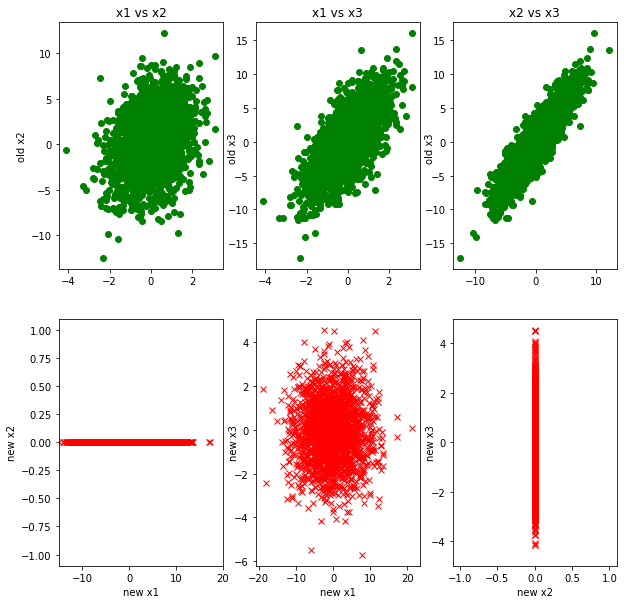

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import linalg as la
%precision 4
np.set_printoptions(suppress=True)

#N=int(input("Insert lenght of numpy"))
N=2000
sigma2=3
x1=np.random.randn(N) #already sigma=1, mean=0 by default
x2=x1+sigma2*np.random.randn(N)
data=np.array([x1,x2,2*x1+x2])
#1)
Cov=np.cov(data)
l, V = la.eig(Cov)
Eig=np.real(l) #real_if_close didn't seem to work even if all were 0j
#2)SVD
U, spectrum, Vt = la.svd(data)
print("It is",np.allclose(np.sort(Eig), np.sort(spectrum**2/(N-1)),rtol=1e-02),"that the 2 methods give almost the same result")
#Principal components
Trace=np.diag(Eig).trace()
print(Eig/Trace)
#as expected two components explain all variability of the set. In fact it is evident x3 is just a linear combination
#of x1 and x2 and so it adds no indipendent variability

Newdata=np.dot(V.T,data)
#print(Newdata[1])

plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.plot(x1, x2 ,'go')
plt.title('x1 vs x2')
plt.ylabel('old x2')

plt.subplot(2,3,2)
plt.plot(x1, 2*x1+x2, 'go')
plt.title('x1 vs x3')
plt.ylabel('old x3 ',labelpad=-10)     
           
plt.subplot(2,3,3)
plt.plot(x2, 2*x1+x2, 'go')
plt.title('x2 vs x3')
plt.ylabel('old x3 ',labelpad=-10)
           
plt.subplot(2,3,4)
plt.plot(Newdata[0],Newdata[1], 'rx')
plt.xlabel('new x1')
plt.ylabel('new x2')
plt.axis([-15, 20, -1.1, 1.1])
          
plt.subplot(2, 3, 5)
plt.plot(Newdata[0],Newdata[2], 'rx')
plt.xlabel('new x1')
plt.ylabel('new x3',labelpad=-5)

plt.subplot(2, 3, 6)
plt.plot(Newdata[1],Newdata[2], 'rx')
plt.xlabel('new x2')
plt.ylabel('new x3',labelpad=-5)
plt.axis([-1.1, 1.1,-5,5])

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

It is True that the 2 methods give almost the same result
[ 0.9302  0.0698  0.      0.     -0.      0.      0.      0.      0.
  0.      0.      0.      0.    ]
[[-3.7042  7.1968 -3.7925 ... -0.706  -2.0816 -6.2102]
 [ 3.1872  0.3178  1.4475 ...  1.0676 -0.8707  1.8135]
 [ 0.0077 -0.0468 -0.013  ...  0.0107 -0.0254 -0.0136]
 ...
 [-0.0061  0.006  -0.0158 ... -0.0038  0.0087 -0.0085]
 [-0.0102  0.01   -0.0021 ...  0.0019  0.0022  0.0038]
 [ 0.0101  0.009  -0.0101 ... -0.0012 -0.0047 -0.0057]]


[-5, 5, -0.5000, 0.5000]

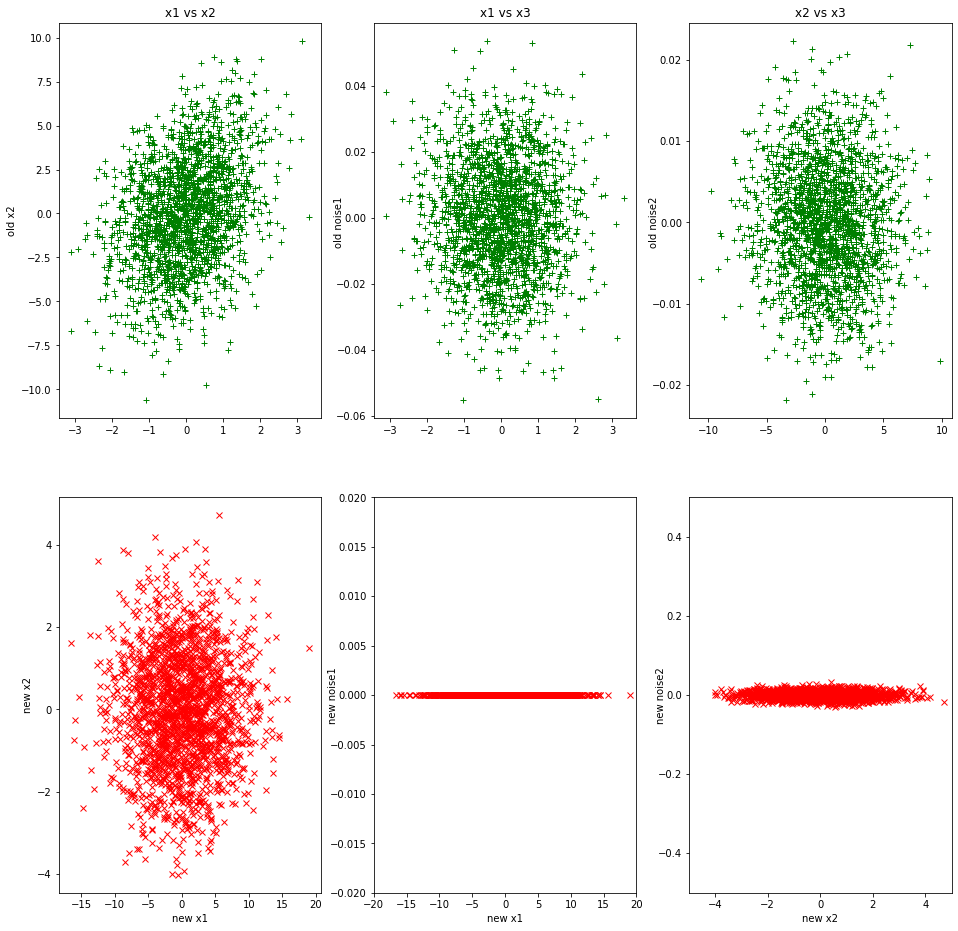

In [4]:
x1=np.random.randn(N) #already sigma=1, mean=0 by default
x2=x1+sigma2*np.random.randn(N)
#noise generation
sigmas=np.array([1/(50+10*i) for i in range(0,10)])
noise=np.empty((N,10))
for i,j in enumerate(sigmas):
    noise[:,i]=np.random.randn(N)*j
old=np.array([x1,x2,2*x1+x2])
data=np.hstack([old.T,noise])
#1)
Cov=np.cov(data.T) #without the transverse Cov is NxN matrix with N=2000
l, V = la.eig(Cov)
Eig=np.real(l) #real_if_close didn't seem to work even if all were 0j
#2)SVD
U, spectrum, Vt = la.svd(data)
print("It is",np.allclose(np.sort(Eig), np.sort(spectrum**2/(N-1)),rtol=1e-02),"that the 2 methods give almost the same result")
#Principal components
Trace=np.diag(Eig).trace()
print(Eig/Trace)
#the number of dimensions with significant variance is not changed because, as expected,
#the variance in the noise is very low since it is generated with low sigma
#and so the only eigenvalues significantly different from 0 are the one of exercise 1

Newdata=np.dot(V.T,data.T)

#we will plot only some combinations: the two significant ones, and each of them with a noise

print (Newdata)

plt.figure(figsize=(16,16))
plt.subplot(2,3,1)
plt.plot(x1, x2 ,'g+')
plt.title('x1 vs x2')
plt.ylabel('old x2')

plt.subplot(2,3,2)
plt.plot(x1, data[:,4], 'g+')
plt.title('x1 vs x3')
plt.ylabel('old noise1 ',labelpad=-8)     
           
plt.subplot(2,3,3)
plt.plot(x2, data[:,-1], 'g+')
plt.title('x2 vs x3')
plt.ylabel('old noise2 ',labelpad=-8)
           
plt.subplot(2,3,4)
plt.plot(Newdata[0],Newdata[1], 'rx')
plt.xlabel('new x1')
plt.ylabel('new x2')
          
plt.subplot(2, 3, 5)
plt.plot(Newdata[0],Newdata[4], 'rx')
plt.xlabel('new x1')
plt.ylabel('new noise1',labelpad=-8)
plt.axis([-20, 20, -0.02, 0.02])

plt.subplot(2, 3, 6)
plt.plot(Newdata[1],Newdata[-1], 'rx')
plt.xlabel('new x2')
plt.ylabel('new noise2',labelpad=-8)
plt.axis([-5, 5,-0.5, 0.5])

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


[ 9.99999821e-01  1.78801776e-07  7.48861476e-17 -8.06970264e-17
 -3.84926369e-17  8.47732521e-18 -1.47762304e-18]


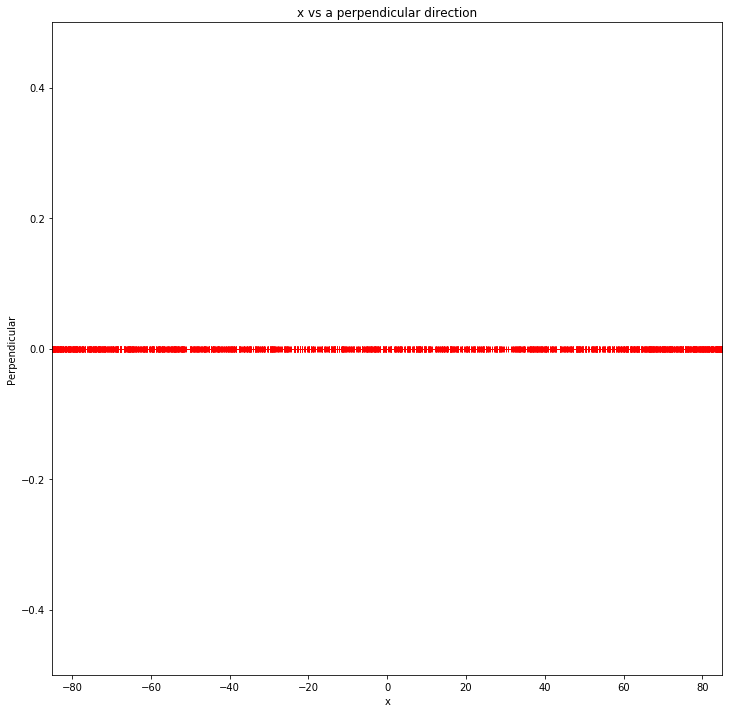

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import linalg as la
import math as mh
import seaborn as sns
#define function that random position of spring
def Spring():
    A=50
    w=3
    i=np.random.uniform(0,2*mh.pi/w)
    return A*mh.cos(w*i)


#N=int(input("Insert lenght of numpy"))
N=2000
x=np.array([Spring() for i in range(0,N)])
y=np.random.randn(N)*0.02 #low sigma to reduce fluctuactions
#plt.hist(x)
Ncams=5
Cams=np.empty(shape=(Ncams,N))
Angles=np.empty(shape=(Ncams,2))
#more or less this means starting with a PCA optimized situation, rotating it to be a "mess"
#and then using the PCA to getting back to original configuration
for i in range(0,Ncams):
    alfa=np.random.uniform(0,mh.pi)             #rotation around X axis
    beta=np.random.uniform(0,2*mh.pi)             #rotation around Z axis
    Cams[i,:]=mh.sin(alfa)*mh.cos(beta)*x+mh.sin(beta)*mh.cos(alfa)*y
Data=np.vstack((x,y,Cams))
#PDA
Cov=np.cov(Data)
l, V = la.eig(Cov)
Eig=np.real(l)
Trace=np.diag(Eig).trace()
print(Eig/Trace)
Newdata=np.dot(V.T,Data)
#as example I will plot the significant row vs one of the others
plt.figure(figsize=(12,12))
plt.plot(Newdata[0], Newdata[-1] ,'r+')
plt.title('x vs a perpendicular direction')
plt.ylabel('Perpendicular')
plt.xlabel('x')
plt.axis([-85, 85,-0.5, 0.5])
plt.show()

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [60]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

--2020-11-25 17:36:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 1477391 (1,4M) [application/x-httpd-php]
Salvataggio in: "/home/giacomo/data/magic04.data"

magic04.data        100%[===================>]   1,41M   277KB/s    in 5,5s    

2020-11-25 17:36:27 (264 KB/s) - "/home/giacomo/data/magic04.data" salvato [1477391/1477391]

--2020-11-25 17:36:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 5400 (5,3K) [application/x-httpd-php]
Salvataggio in: "/home/giaco

[0.4405 0.258  0.135  0.0888 0.0408 0.029  0.0079 0.     0.     0.    ]


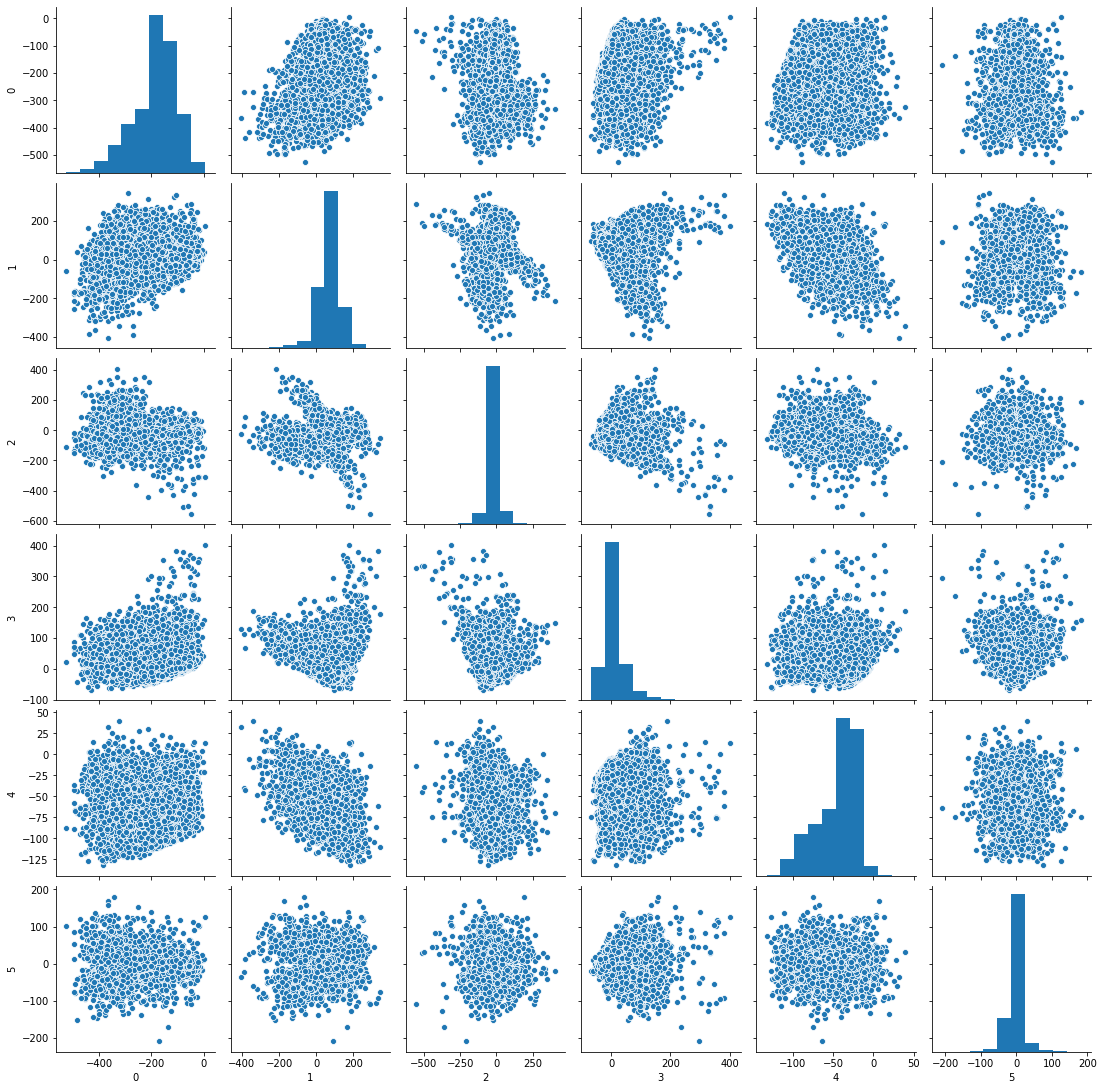

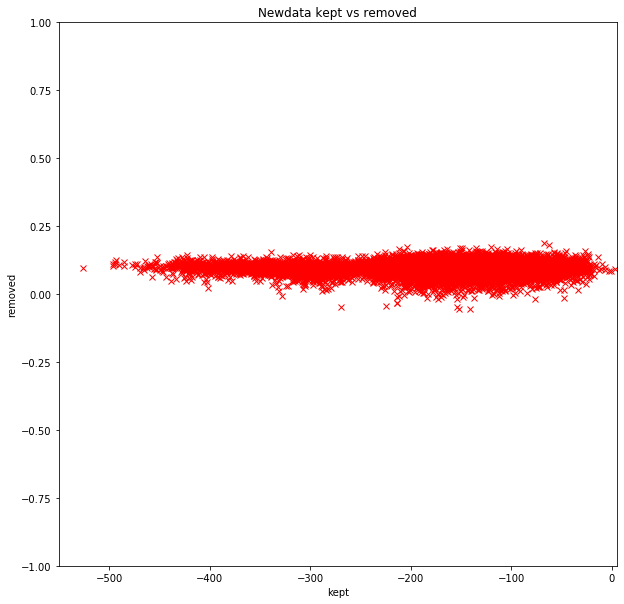

In [5]:
import seaborn as sns
file_name="~/data/magic04.data"
data=pd.read_csv(file_name, header=None)
Dataset=np.array(data.iloc[:,0:10])
#looking with seaborn(for my curiosity), deactivated to improve performance (ofc vey memory consuming)
#sns.pairplot(data.iloc[:,0:10])
#PDA
Cov=np.cov(Dataset.T)
l, V = la.eig(Cov)
Eig=np.real(l)
Trace=np.diag(Eig).trace()
print(Eig/Trace)
#so 3 variables have negligible variance,and another is <1%
Newdata=np.dot(V.T,Dataset.T)
#rows are the features, if we remove the last 4, we still keep more than 99% the variance
Onlysome=pd.DataFrame(Newdata[0:-4])
sns.pairplot(Onlysome.T)  #WARNING:very memory consuming
#I will only plot the first row of  significant variables vs the discarded one to show 
#that indeed we only cut out less significant combination of variables
plt.figure(figsize=(10,10))
plt.plot(Newdata[0],Newdata[-1] ,'rx')
plt.title('Newdata kept vs removed')
plt.ylabel('removed')
plt.xlabel('kept')
plt.axis([-550, 5,-1, 1])
plt.show()